In [1]:
import mysql.connector
from mysql.connector import Error

def retrieve_plate():
    try:
        print("Trying to connect to database.")
        connection = mysql.connector.connect(
            host='localhost',
            port=3306,
            database='constructal_automate_mcsul_2024_results',
            user='constructal_automate',
            password='constructal_design_2024'
        )
        
        if connection.is_connected():
            print("Connected to database successfully.")
            cursor = connection.cursor()
            
            # Query SQL
            query = """
                SELECT id FROM csg_stiffenedplate sp
                WHERE sp.phi = 0.3
                  AND sp.N_ts = 2
                  AND sp.N_ls = 2
                  AND sp.k = 3.2;
            """
            
            # Executa a query
            cursor.execute(query)
            
            # Busca todos os resultados
            results = cursor.fetchall()
            
            # Extrai os ids para a lista stiffened_plates_to_analyse
            plates_to_analyse = [row[0] for row in results]
            
            print(f" {len(plates_to_analyse)} Found IDs: {plates_to_analyse}")
            return plates_to_analyse
            
    except Error as e:
        print(f"Unable to connect to database: {e}")
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()
            print("Database connection closed.")

# Chama a função
plates_to_analyse = retrieve_plate()


Trying to connect to database.
Connected to database successfully.
 1 Found IDs: [2]
Database connection closed.


In [2]:
import requests
from requests.auth import HTTPBasicAuth
import time
import pandas as pd

# Configurações da API
STIFFENED_PLATE_ANALYSIS_BASE_URL = 'http://127.0.0.1:8000/stiffened-plate-analysis/'
ELASTIC_BUCKLING_BASE_URL = 'http://127.0.0.1:8000/elastic-buckling/'
ELASTO_PLASTIC_BUCKLING_BASE_URL = 'http://127.0.0.1:8000/elasto-plastic-buckling/'
USERNAME = 'andreiflancanova'
PASSWORD = 'teste1234'

# Função genérica para fazer uma requisição POST e medir o tempo
def make_request(url, request_body, context):
    try:
        start_time = time.time()  # Medir tempo de início

        response = requests.post(url, json=request_body, auth=HTTPBasicAuth(USERNAME, PASSWORD))
        response_json = response.json()

        duration = time.time() - start_time  # Duração da requisição

        # Tratamento de erros de resposta HTTP
        if response.status_code == 201:
            id = response_json.get("id")
            print(f"{response_json}")
            print("\n")
            return id, duration
        elif response.status_code == 400:
            print(f"Erro de validação")
            print(f"Request Body: {request_body}")
            print(f"Status Code: {response.status_code}")
            print("Response: \n")
            print(f"{response_json}")
            return None, duration
        elif response.status_code == 401:
            print(f"{context}: Falha na autenticação. Verifique suas credenciais.")
            return None, duration
        else:
            print("Erro inesperado na requisição")
            print(f"Request Body: {request_body}")
            print(f"Status Code: {response.status_code}")
            print("Response: \n")
            print(f"{response_json}")
            return None, duration
    except requests.exceptions.RequestException as e:
        print(f"{context}: Erro de conexão ou de requisição: {e}")
        return None, None

# Funções específicas para cada tipo de requisição
def generate_stiffened_plate_analysis(mesh_size, buckling_load_type, case_study, material, stiffened_plate_id):
    request_body = {
        "mesh_size": mesh_size,
        "buckling_load_type": buckling_load_type,
        "case_study": case_study,
        "material": material,
        "stiffened_plate": stiffened_plate_id
    }
    return make_request(STIFFENED_PLATE_ANALYSIS_BASE_URL, request_body, "STIFFENED_PLATE_ANALYSIS")

def generate_elastic_buckling(stiffened_plate_analysis_id):
    request_body = {
        "stiffened_plate_analysis": stiffened_plate_analysis_id
    }
    return make_request(ELASTIC_BUCKLING_BASE_URL, request_body, "ELASTIC_BUCKLING")

def generate_elasto_plastic_buckling(stiffened_plate_analysis_id):
    request_body = {
        "stiffened_plate_analysis": stiffened_plate_analysis_id
    }
    return make_request(ELASTO_PLASTIC_BUCKLING_BASE_URL, request_body, "ELASTO_PLASTIC_BUCKLING")

# Função principal para realizar as três requisições em sequência e gerar a planilha
def execute_analise(mesh_size, buckling_load_type, case_study, material, stiffened_plate_id):

    # Executar as três requisições e capturar tempos
    print("STIFFENED PLATE ANALYSIS")
    id_spa, elapsed_time_spa = generate_stiffened_plate_analysis(mesh_size, buckling_load_type, case_study, material, stiffened_plate_id)

    print("ELASTIC BUCKLING")
    id_eb, elapsed_time_eb = generate_elastic_buckling(id_spa)
    print("ELASTO-PLASTIC BUCKLING")
    id_epb, elapsed_time_epb = generate_elasto_plastic_buckling(id_spa)
    return stiffened_plate_id, id_spa, elapsed_time_spa, id_eb, elapsed_time_eb, id_epb, elapsed_time_epb

def mesh_convergency_test(mesh_size_list, buckling_load_type, case_study, material, stiffened_plate_id):
    for mesh_size in mesh_size_list:
        try:
            execute_analise(mesh_size, buckling_load_type, case_study, material, stiffened_plate_id)
        except:
            continue

In [3]:
mesh_size_list = [100, 75, 50, 40, 25, 20, 15, 10]
# mesh_size_list = [25]
buckling_load_type = 1
case_study = 'mesh_convergency_1a_2_2_sp_t1_20'
material = 1
stiffened_plate_id = 2

In [4]:
mesh_convergency_test(mesh_size_list, buckling_load_type, case_study, material, stiffened_plate_id)

STIFFENED PLATE ANALYSIS
{'id': 50, 'mesh_size': '100.0', 'num_elem': 318, 'case_study': 'mesh_convergency_1a_2_2_sp_t1_20', 'analysis_dir_path': 'D:/constructal_automate_analysis_files/mesh_convergency_1a_2_2_sp_t1_20/BL1M1P0.3L2T2_k3.2_MS100_SP2', 'analysis_rst_file_path': None, 'analysis_lgw_file_path': 'D:/constructal_automate_analysis_files/mesh_convergency_1a_2_2_sp_t1_20/BL1M1P0.3L2T2_k3.2_MS100_SP2/BL1M1P0.3L2T2_k3.2_MS100_SP2.txt', 'material': 1, 'stiffened_plate': 2, 'buckling_load_type': 1, 'elastic_buckling_status': 1, 'elasto_plastic_buckling_status': 1}


ELASTIC BUCKLING
{'id': 50, 'n_cr': '37245.94', 'sigma_cr': '1862.30', 'w_center': '1.0000', 'stiffened_plate_analysis': 50}


ELASTO-PLASTIC BUCKLING
{'id': 50, 'p_u': '7100.00', 'n_u': '6997.94', 'sigma_u': '349.90', 'w_max': '0.7189', 'w_dist_img_path': 'D:/constructal_automate_analysis_files/mesh_convergency_1a_2_2_sp_t1_20/BL1M1P0.3L2T2_k3.2_MS100_SP2/BL1M1P0.3L2T2_k3.2_MS100_SP2_w_dist.png', 'von_mises_dist_img_pat

[Decimal('353.60'), Decimal('353.60'), Decimal('354.48'), Decimal('354.48'), Decimal('354.48'), Decimal('354.48'), Decimal('354.48'), Decimal('354.48')]


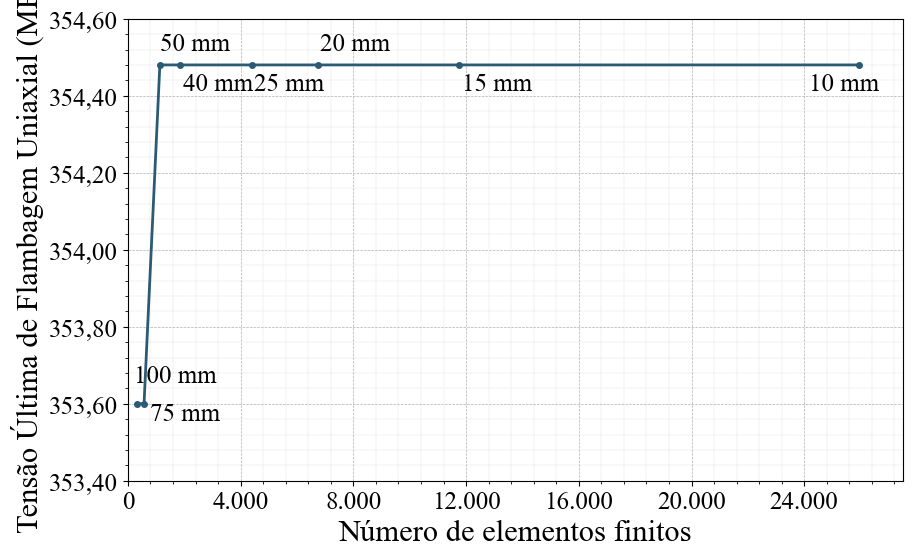

In [2]:
import mysql.connector
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
from decimal import Decimal
from matplotlib.ticker import AutoMinorLocator, FuncFormatter,MultipleLocator
import matplotlib.ticker as ticker
import locale
locale.setlocale(locale.LC_NUMERIC, 'pt_BR.UTF-8')

plt.rcParams['axes.formatter.use_locale'] = True
plt.rcParams['font.family'] = 'Lucida Sans'

# 1. Conectar ao banco de dados MySQL
con = mysql.connector.connect(
    host="localhost",        
    user="constructal_automate",     
    password="constructal_design_2024",    
    database="constructal_automate_mcsul_2024_results"
)

cur = con.cursor()

query = f'''
SELECT spa.num_elem, epb.sigma_u, spa.mesh_size FROM constructal_automate_mcsul_2024_results.cbeb_elastoplasticbuckling as epb
INNER JOIN constructal_automate_mcsul_2024_results.cbeb_stiffenedplateanalysis as spa on epb.stiffened_plate_analysis_id=spa.id
INNER JOIN constructal_automate_mcsul_2024_results.csg_stiffenedplate as sp on spa.stiffened_plate_id=sp.id
WHERE sp.id=2 and spa.id BETWEEN 9 and 16;
'''
cur.execute(query)
dados = cur.fetchall()

min_elem_amount = 0
max_elem_amount = 27500
min_sigma_u = 353.4
max_sigma_u = 354.6

elem_data = [row[0] for row in dados]
sigma_u_data = [row[1] for row in dados]
print(sigma_u_data)
labels = [row[2] for row in dados]
            
# Criar o gráfico
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(elem_data, sigma_u_data, '-o', color='#2b5a74', lw=2, markersize=4)

formatter = ticker.FuncFormatter(lambda x, _: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.'))
ax.yaxis.set_major_formatter(formatter)

# Configurar rótulos dos eixos e legenda
ax.set_xlabel(r'Número de elementos finitos', fontsize=22)
ax.set_ylabel('Tensão Última de Flambagem Uniaxial (MPa)', fontsize=22)
# ax.legend(loc='lower left')

# Adicionar a malha ao gráfico
ax.grid(True)

point_fontsize = 18

# Definir os limites dos eixos, se necessário
ax.set_xlim([min_elem_amount, max_elem_amount])  # Limites do eixo X
ax.set_ylim([min_sigma_u, max_sigma_u])  # Limites do eixo Y

for x, y, label in zip(elem_data, sigma_u_data, labels):
    if x == elem_data[0]:
        ax.text(x - 100, y + Decimal(0.04), f'{label:.0f} mm', fontsize=point_fontsize, ha='left', va='bottom')
    elif x == elem_data[1]:
        ax.text(x + 200, y - Decimal(0.06), f'{label:.0f} mm', fontsize=point_fontsize, ha='left', va='bottom')
    elif x == elem_data[2]:
        ax.text(x, y + Decimal(0.02), f'{label:.0f} mm', fontsize=point_fontsize, ha='left', va='bottom')
    elif x == elem_data[5]:
        ax.text(x + 100, y + Decimal(0.02), f'{label:.0f} mm', fontsize=point_fontsize, ha='left', va='bottom')
    elif x == elem_data[-1]:
        ax.text(x - 1800, y - Decimal(0.02), f'{label:.0f} mm', fontsize=point_fontsize, ha='left', va='top')
    else:
        ax.text(x + 100, y - Decimal(0.02), f'{label:.0f} mm', fontsize=point_fontsize, ha='left', va='top')

ax.grid(True, linestyle='--', linewidth=0.5, which='major')  # Grade principal
ax.grid(True, linestyle=':', linewidth=0.3, which='minor')   # Grade secundária

ax.xaxis.set_major_locator(MultipleLocator(4000))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

ax.set_xlim([0, max_elem_amount])  # Limites do eixo X
ax.set_ylim([min_sigma_u, max_sigma_u])  # Limites do eixo Y
ax.tick_params(axis='both', labelsize=18) #18 aqui equivale a 12 no word
# Salvar o gráfico com o timestamp e valores de N_ls e N_ts no nome do arquivo
plt.savefig(f'resultados_artigo_mcsul2024/epb1a_mcsp.png')

# Exibir o gráfico
plt.show()

# Fechar a conexão com o banco de dados
con.close()

[Decimal('353.60'), Decimal('353.60'), Decimal('354.48'), Decimal('354.48'), Decimal('354.48'), Decimal('354.48'), Decimal('354.48'), Decimal('354.48')]


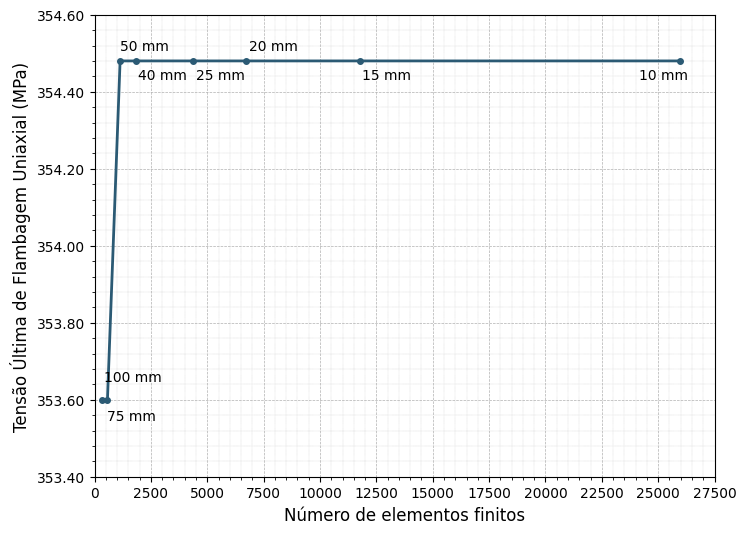

In [13]:
import mysql.connector
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
from decimal import Decimal
from matplotlib.ticker import AutoMinorLocator, FuncFormatter, MultipleLocator

# 1. Conectar ao banco de dados MySQL
con = mysql.connector.connect(
    host="localhost",        
    user="constructal_automate",     
    password="constructal_design_2024",    
    database="constructal_automate_mcsul_2024_results"
)

cur = con.cursor()

query = f'''
SELECT spa.num_elem, epb.sigma_u, spa.mesh_size FROM constructal_automate_mcsul_2024_results.cbeb_elastoplasticbuckling as epb
INNER JOIN constructal_automate_mcsul_2024_results.cbeb_stiffenedplateanalysis as spa on epb.stiffened_plate_analysis_id=spa.id
INNER JOIN constructal_automate_mcsul_2024_results.csg_stiffenedplate as sp on spa.stiffened_plate_id=sp.id
WHERE sp.id=2;
'''
cur.execute(query)
dados = cur.fetchall()

min_elem_amount = 0
max_elem_amount = 27500
min_sigma_u = 353.4
max_sigma_u = 354.6

elem_data = [row[0] for row in dados]
sigma_u_data = [row[1] for row in dados]
print(sigma_u_data)
labels = [row[2] for row in dados]
            
# Criar o gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(elem_data, sigma_u_data, label=f'P({N_ls}, {N_ts})', color='red')
# ax.plot(elem_data, sigma_u_data, label=r'$\sigma_{u,1A}$', color='red')
ax.plot(elem_data, sigma_u_data, '-o', color='#2b5a74', lw=2, markersize=4)

# ax.plot(eixo_x, eixo_y_andrei, '-o', color='blue', lw=2.5, markersize=8, label=r'$\sigma_{u}$')
# ax.plot(eixo_x, eixo_y_lima, '-o', color='orange', lw=1.5, markersize=6, label=r'$b2f2a=f=0.60$')

# Configurar rótulos dos eixos e legenda
ax.set_xlabel(r'Número de elementos finitos', fontsize=12)
# ax.set_ylabel(r'$\sigma_{u,1A}$', fontsize=12)
ax.set_ylabel('Tensão Última de Flambagem Uniaxial (MPa)', fontsize=12)
# ax.legend(loc='lower left')

# Adicionar a malha ao gráfico
ax.grid(True)

# Definir os limites dos eixos, se necessário
ax.set_xlim([min_elem_amount, max_elem_amount])  # Limites do eixo X
ax.set_ylim([min_sigma_u, max_sigma_u])  # Limites do eixo Y

for x, y, label in zip(elem_data, sigma_u_data, labels):
    if x == elem_data[0]:
        ax.text(x + 100, y + Decimal(0.04), f'{label:.0f} mm', fontsize=10, ha='left', va='bottom')
    elif x == elem_data[1]:
        ax.text(x, y - Decimal(0.06), f'{label:.0f} mm', fontsize=10, ha='left', va='bottom')
    elif x == elem_data[2]:
        ax.text(x, y + Decimal(0.02), f'{label:.0f} mm', fontsize=10, ha='left', va='bottom')
    elif x == elem_data[5]:
        ax.text(x + 100, y + Decimal(0.02), f'{label:.0f} mm', fontsize=10, ha='left', va='bottom')
    elif x == elem_data[-1]:
        ax.text(x - 1800, y - Decimal(0.02), f'{label:.0f} mm', fontsize=10, ha='left', va='top')
    else:
        ax.text(x + 100, y - Decimal(0.02), f'{label:.0f} mm', fontsize=10, ha='left', va='top')

ax.grid(True, linestyle='--', linewidth=0.5, which='major')  # Grade principal
ax.grid(True, linestyle=':', linewidth=0.3, which='minor')   # Grade secundária

ax.xaxis.set_major_locator(MultipleLocator(2500))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

ax.set_xlim([0, max_elem_amount])  # Limites do eixo X
ax.set_ylim([min_sigma_u, max_sigma_u])  # Limites do eixo Y
# Salvar o gráfico com o timestamp e valores de N_ls e N_ts no nome do arquivo
plt.savefig(f'resultados_artigo_mcsul2024/epb1a_mcsp.png')

# Exibir o gráfico
plt.show()

# Fechar a conexão com o banco de dados
con.close()

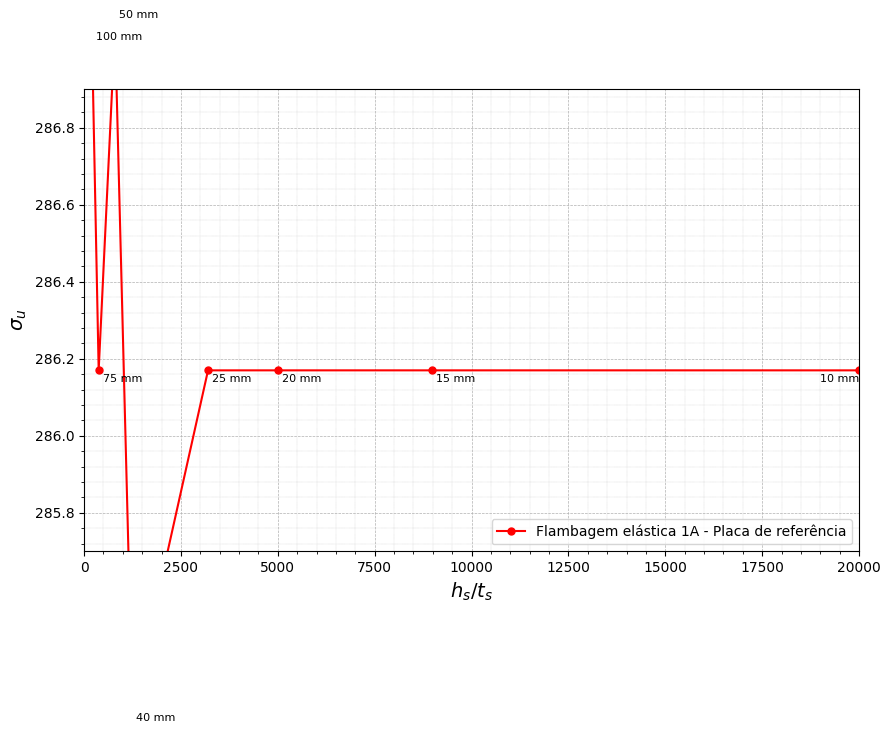

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from decimal import Decimal

# Dados de exemplo que você obtém da sua consulta SQL
# Suponha que 'elem_data' e 'sigma_u_data' já estejam preenchidos com dados do banco
# elem_data = [100, 500, 1000, 2000, 4000, 8000, 16000, 20000]  # Exemplo de dados
# sigma_u_data = [286.5, 286.8, 286.9, 286.95, 287, 287, 286.9, 286.85]  # Exemplo de dados

# Criar o gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Configurar a linha principal e os marcadores
ax.plot(elem_data, sigma_u_data, label='Flambagem elástica 1A - Placa de referência', color='red', marker='o', linestyle='-', markersize=5)
ax.set_xlabel(r'$h_{s}/t_{s}$', fontsize=14)
ax.set_ylabel(r'$\sigma_{u}$', fontsize=14)

# Adicionar rótulos aos marcadores com deslocamento
for x, y, label in zip(elem_data, sigma_u_data, labels):
    if x == elem_data[2]:
        ax.text(x + 100, y + Decimal(0.02), f'{label:.0f} mm', fontsize=8, ha='left', va='bottom')  # Ajuste de posição dos rótulos
    elif x == elem_data[-1]:
        ax.text(x - 1000, y - Decimal(0.01), f'{label:.0f} mm', fontsize=8, ha='left', va='top')  # Ajuste de posição dos rótulos
    else:
        ax.text(x + 100, y - Decimal(0.01), f'{label:.0f} mm', fontsize=8, ha='left', va='top')  # Ajuste de posição dos rótulos

# Configurações do gráfico
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, which='major')  # Grade principal
ax.grid(True, linestyle=':', linewidth=0.3, which='minor')   # Grade secundária

ax.xaxis.set_minor_locator(AutoMinorLocator(5))  # Linhas secundárias em X (dividir em 4)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # Linhas secundárias em Y (dividir em 4)

ax.set_xlim([0, 20000])  # Limites do eixo X
ax.set_ylim([285.7, 286.9])  # Limites do eixo Y

# Exibir o gráfico
plt.show()


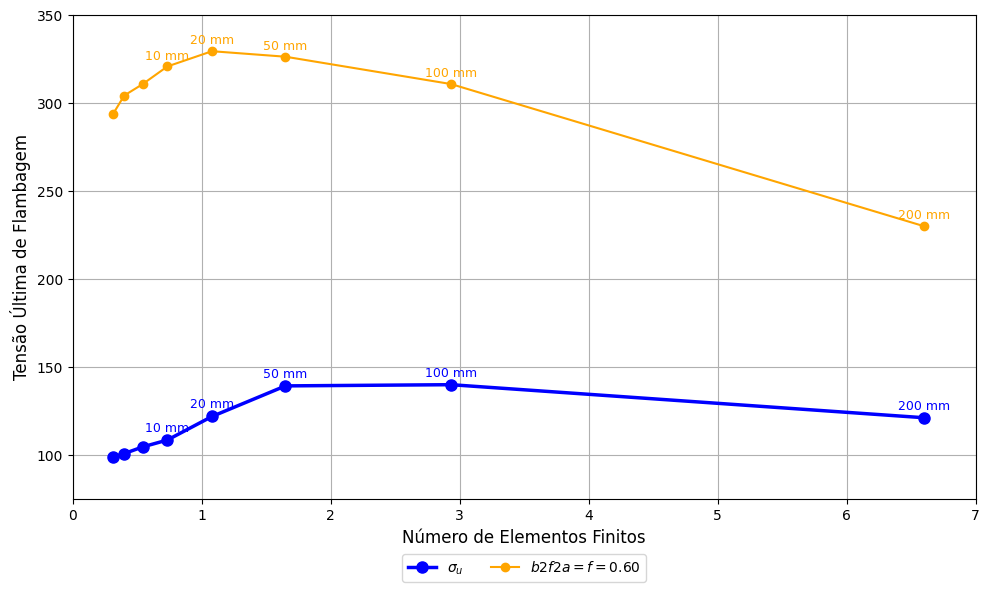

In [108]:
import matplotlib.pyplot as plt

# Dados de exemplo
eixo_x =  [6.6, 2.934, 1.65, 1.08, 0.734, 0.543, 0.4, 0.312]
eixo_y_andrei = [121.28,140.06,139.38,121.99,108.61,104.70,100.91,98.83]
eixo_y_lima = [230.13,310.92,326.47,329.60,320.93,310.91,304.42,293.78]

# Criando a figura
fig, ax = plt.subplots(figsize=(10, 6))

# Plotando as linhas com estilos e rótulos
ax.plot(eixo_x, eixo_y_andrei, '-o', color='blue', lw=2.5, markersize=8, label=r'$\sigma_{u}$')
ax.plot(eixo_x, eixo_y_lima, '-o', color='orange', lw=1.5, markersize=6, label=r'$b2f2a=f=0.60$')
# ax.plot(eixo_x, tensao_b2f2a_eq_1_00, '-o', color='gray', lw=1.5, markersize=6, label=r'$b2f2a=f=1.00$')

# Adicionando anotações para cada ponto específico
labels = ['200 mm', '100 mm', '50 mm', '20 mm', '10 mm']
for i, txt in enumerate(labels):
    ax.annotate(txt, (eixo_x[i], eixo_y_andrei[i]), textcoords="offset points", xytext=(0,6), ha='center', color='blue', fontsize=9)
    ax.annotate(txt, (eixo_x[i], eixo_y_lima[i]), textcoords="offset points", xytext=(0,5), ha='center', color='orange', fontsize=9)
#     ax.annotate(txt, (num_elementos[i], tensao_b2f2a_eq_1_00[i]), textcoords="offset points", xytext=(0,5), ha='center', color='gray', fontsize=9)

# Configurações dos eixos
ax.set_xlabel('Número de Elementos Finitos', fontsize=12)
ax.set_ylabel('Tensão Última de Flambagem', fontsize=12)
ax.set_ylim(75, 350)
ax.set_xlim(0, 7)

# Exibindo a legenda na parte inferior
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=10)

# Adicionando a grade
plt.grid(True)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

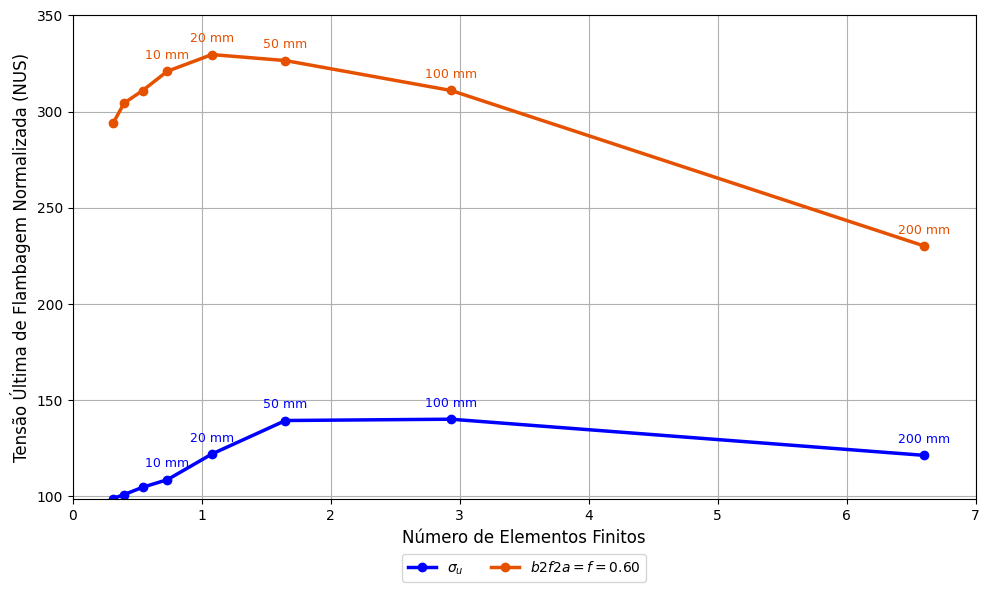

In [12]:
import matplotlib.pyplot as plt

# Dados de exemplo
eixo_x =  [6.6, 2.934, 1.65, 1.08, 0.734, 0.543, 0.4, 0.312]
eixo_y_andrei = [121.28,140.06,139.38,121.99,108.61,104.70,100.91,98.83]
eixo_y_lima = [230.13,310.92,326.47,329.60,320.93,310.91,304.42,293.78]

# Criando a figura
fig, ax = plt.subplots(figsize=(10, 6))

# Plotando as linhas com estilos e rótulos
ax.plot(eixo_x, eixo_y_andrei, '-o', color='blue', lw=2.5, markersize=6, label=r'$\sigma_{u}$')
ax.plot(eixo_x, eixo_y_lima, '-o', color='#e65100', lw=2.5, markersize=6, label=r'$b2f2a=f=0.60$')
# ax.plot(eixo_x, tensao_b2f2a_eq_1_00, '-o', color='gray', lw=1.5, markersize=6, label=r'$b2f2a=f=1.00$')

# Adicionando anotações para cada ponto específico
labels = ['200 mm', '100 mm', '50 mm', '20 mm', '10 mm']
for i, txt in enumerate(labels):
    ax.annotate(txt, (eixo_x[i], eixo_y_andrei[i]), textcoords="offset points", xytext=(0,9), ha='center', color='blue', fontsize=9)
    ax.annotate(txt, (eixo_x[i], eixo_y_lima[i]), textcoords="offset points", xytext=(0,9), ha='center', color='#e65100', fontsize=9)
#     ax.annotate(txt, (num_elementos[i], tensao_b2f2a_eq_1_00[i]), textcoords="offset points", xytext=(0,5), ha='center', color='gray', fontsize=9)

# Configurações dos eixos
ax.set_xlabel('Número de Elementos Finitos', fontsize=12)
ax.set_ylabel('Tensão Última de Flambagem Normalizada (NUS)', fontsize=12)
ax.set_ylim(98.5, 350)
ax.set_xlim(0, 7)

# Exibindo a legenda na parte inferior
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=10)

# Adicionando a grade
plt.grid(True)

# Exibindo o gráfico
plt.tight_layout()
plt.show()